# 02e — Magnetics Features (USGS NAMAG → Missouri grid)

This notebook clips the USGS North American Magnetic Anomaly (NAMAG) GeoTIFF to
Missouri, samples per-cell values at grid centroids, computes simple derivatives
(HGM and tilt), and saves features for modeling:

- `data/processed/X_mag.npy`  → shape (n_cells, 3)
- `data/processed/feature_names_mag.json` → `["mag_val","mag_hgm","mag_tilt"]`

**Input expected:**
- `data/raw/mag_conus.tif`  ← the GeoTIFF from **GeophysicsMag_USCanada.zip**
  (US & Canada residual magnetic anomaly, nT, EPSG:4326).

We preserve nodata and mask it to NaN before sampling to avoid blank maps.
 


In [17]:
##  1) Imports & config
# %pip install -q rasterio

import os, json, sys
import numpy as np
import rasterio
import rasterio.mask
import joblib
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import box, mapping
from pathlib import Path

# Make 'src/' importable
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

RAW_PATH  = project_root / "data/raw/mag_conus.tif"   # <- put the NAMAG GeoTIFF here
CLIP_PATH = project_root / "data/raw/mag_mo.tif"

OUT_NPY   = project_root / "data/processed/X_mag.npy"
OUT_JSON  = project_root / "data/processed/feature_names_mag.json"

# Load authoritative grid (same used everywhere else)
grid = joblib.load(project_root / "data/processed/grid_gdf.joblib")
if grid.crs is None:
    grid = grid.set_crs(4326)
elif grid.crs.to_epsg() != 4326:
    grid = grid.to_crs(4326)

bbox = grid.total_bounds  # (minx, miny, maxx, maxy)
print("Grid cells:", len(grid))
print("Input raster:", RAW_PATH)
print("Grid bbox:", bbox)



Grid cells: 7646
Input raster: c:\Users\angel\ore-exploration-ml\ore-exploration-ml\data\raw\mag_conus.tif
Grid bbox: [-95.77435509  35.99560302 -89.07435509  40.64560302]


In [18]:
## 2) Clip the big GeoTIFF to Missouri bbox (preserve nodata)
os.makedirs(project_root / "data/raw", exist_ok=True)

with rasterio.open(RAW_PATH) as src:
    print("SRC CRS:", src.crs)
    print("SRC bounds:", src.bounds)
    print("SRC nodata:", src.nodata)

    # Build a bbox polygon in the raster’s CRS (here the raster should be EPSG:4326)
    minx, miny, maxx, maxy = bbox
    bbox_poly = box(minx, miny, maxx, maxy)

    # Clip using geometry; this preserves nodata correctly
    out_arr, out_transform = rasterio.mask.mask(
        src, [mapping(bbox_poly)], crop=True
    )
    out_meta = src.meta.copy()
    out_meta.update({
        "height": out_arr.shape[1],
        "width":  out_arr.shape[2],
        "transform": out_transform,
        "nodata": src.nodata
    })

with rasterio.open(CLIP_PATH, "w", **out_meta) as dst:
    dst.write(out_arr)

print("Wrote clipped raster:", CLIP_PATH, "| shape:", out_arr.shape)
print("Clipped min/max (raw):", np.nanmin(out_arr), np.nanmax(out_arr))


SRC CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
SRC bounds: BoundingBox(left=-187.454155, bottom=24.619315000000007, right=-52.674754999999976, top=82.44617500000001)
SRC nodata: -3.4028234663852886e+38
Wrote clipped raster: c:\Users\angel\ore-exploration-ml\ore-exploration-ml\data\raw\mag_mo.tif | shape: (1, 559, 806)
Clipped min/max (raw): -3.4028235e+38 1554.7545
Wrote clipped raster: c:\Users\angel\ore-exploration-ml\ore-exploration-ml\data\raw\mag_mo.tif | shape: (1, 559, 806)
Clipped min/max (raw): -3.4028235e+38 1554.7545


In [19]:
## 3) Sample per-cell value at grid centroids

# Sample the clipped raster at grid centroids (fast & robust)
# Compute centroids in projected CRS, then bring to EPSG:4326 for sampling
grid_proj = grid.to_crs("EPSG:5070")
cent_proj = grid_proj.geometry.centroid
centroids = gpd.GeoSeries(cent_proj, crs="EPSG:5070").to_crs("EPSG:4326")

vals = np.empty(len(centroids), dtype=np.float32)

with rasterio.open(CLIP_PATH) as src:
    band = src.read(1).astype(float)
    if src.nodata is not None:
        band[band == src.nodata] = np.nan

    vals = np.empty(len(centroids), dtype=np.float32)
    for i, pt in enumerate(centroids):
        row, col = src.index(pt.x, pt.y)  # <-- correct order
        if 0 <= row < band.shape[0] and 0 <= col < band.shape[1]:
            vals[i] = band[row, col]
        else:
            vals[i] = np.nan

vals = np.nan_to_num(vals, nan=float(np.nanmean(vals)))
mag_val = vals.astype(np.float32)

print("Sampled per-cell values — shape:", mag_val.shape,
      "| min/max:", float(mag_val.min()), float(mag_val.max()))



Sampled per-cell values — shape: (7646,) | min/max: -543.9879150390625 1527.9171142578125


In [20]:
## 4) Derivatives (HGM & tilt) and centroid sampling

# Compute simple derivatives on the clipped grid and sample to cells
with rasterio.open(CLIP_PATH) as src:
    z = src.read(1).astype(float)
    nod = src.nodata

if nod is not None:
    z[z == nod] = np.nan
z = np.nan_to_num(z, nan=np.nanmean(z))

gy, gx = np.gradient(z)
hgm = np.hypot(gx, gy)
gxx, _ = np.gradient(gx)
_, gyy = np.gradient(gy)
vz = gxx + gyy
tilt = np.arctan2(vz, hgm + 1e-9)

mag_hgm  = np.empty_like(mag_val)
mag_tilt = np.empty_like(mag_val)

with rasterio.open(CLIP_PATH) as src:
    for i, pt in enumerate(centroids):
        row, col = src.index(pt.x, pt.y)  # <-- correct order
        if 0 <= row < z.shape[0] and 0 <= col < z.shape[1]:
            mag_hgm[i]  = hgm[row, col]
            mag_tilt[i] = tilt[row, col]
        else:
            mag_hgm[i]  = np.nan
            mag_tilt[i] = np.nan

mag_hgm  = np.nan_to_num(mag_hgm,  nan=float(np.nanmean(mag_hgm))).astype(np.float32)
mag_tilt = np.nan_to_num(mag_tilt, nan=float(np.nanmean(mag_tilt))).astype(np.float32)

print("HGM min/max:", float(mag_hgm.min()), float(mag_hgm.max()))
print("Tilt min/max:", float(mag_tilt.min()), float(mag_tilt.max()))

HGM min/max: 0.1330750584602356 374.8226013183594
Tilt min/max: -1.5214897394180298 1.534900426864624


In [21]:
# % NODATA after clipping (should be ~0 inside MO bbox)
with rasterio.open(CLIP_PATH) as src:
    z = src.read(1)
    nod = src.nodata
mask = z != nod if nod is not None else np.isfinite(z)
print("Pct NODATA in clip:", 100*(~mask).sum()/mask.size, "%")


Pct NODATA in clip: 0.43413220168947564 %


In [22]:
## 5) Save the processed features
X_mag = np.column_stack([mag_val, mag_hgm, mag_tilt]).astype(np.float32)
names = ["mag_val", "mag_hgm", "mag_tilt"]

os.makedirs(project_root / "data/processed", exist_ok=True)
np.save(OUT_NPY, X_mag)
with open(OUT_JSON, "w") as f:
    json.dump(names, f)

print("Saved:", OUT_NPY, X_mag.shape)
print("Saved:", OUT_JSON, names)


Saved: c:\Users\angel\ore-exploration-ml\ore-exploration-ml\data\processed\X_mag.npy (7646, 3)
Saved: c:\Users\angel\ore-exploration-ml\ore-exploration-ml\data\processed\feature_names_mag.json ['mag_val', 'mag_hgm', 'mag_tilt']


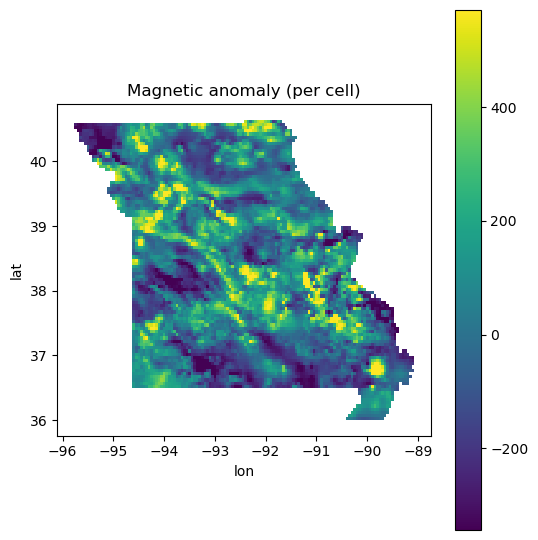

In [23]:
## 6) Visualize the results
import matplotlib.pyplot as plt

tmp = grid.copy()
tmp["mag_val"] = mag_val
vmin, vmax = np.nanpercentile(mag_val, [2, 98])

fig, ax = plt.subplots(figsize=(5.5, 5.5))
tmp.plot(column="mag_val", cmap="viridis", vmin=vmin, vmax=vmax, legend=True, ax=ax)
ax.set_title("Magnetic anomaly (per cell)")
ax.set_xlabel("lon"); ax.set_ylabel("lat")
plt.tight_layout()
plt.savefig(project_root / "figures/magnetic_anomaly.png", dpi=180)
plt.show()
